# Исходные данные


 - Признаки: пол, возраст и зарплата застрахованного, количество членов его семьи.
 - Целевой признак: количество страховых выплат клиенту за последние 5 лет.

# Задача

Защитить данные клиентов страховой компании «Хоть потоп».

 - разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. 
 - обосновать корректность работы метода.
 - при преобразовании качество моделей машинного обучения не должно ухудшаться. 
 
Подбирать наилучшую модель не требуется.

# Ход работы

## Обзор данных


In [1]:
# импорт библиотек

import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
# открытие файла

try:
    data = pd.read_csv('insurance.csv')
except:
    data = pd.read_csv('/datasets/insurance.csv')   

In [3]:
# обзор данных

data.head(10)

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
5,1,43.0,41000.0,2,1
6,1,39.0,39700.0,2,0
7,1,25.0,38600.0,4,0
8,1,36.0,49700.0,1,0
9,1,32.0,51700.0,1,0


In [4]:
# обзор данных

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [5]:
# обзор данных

data.shape

(5000, 5)

<AxesSubplot:>

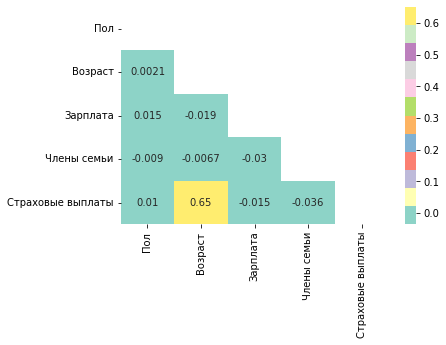

In [6]:
# проверка корреляции признаков

triangle = np.triu(data.corr())

sns.heatmap(data.corr(), 
            annot = True,
            cmap = 'Set3',
            mask = triangle
           )

<div class="alert alert-info">

**Вывод**

 - В данных нет пропусков, все данные численного формата
 - Тип данных колонки возраст можно заменить на целочисленный 
 - Для корректной работы линейной регрессии необходимо применить стандартизацию - размерность данных по клонкам сильно отличается
 - Корреляции между признаками не выявлено
 

## Предобработка 

In [7]:
# замена типа данных

data['Возраст'] = data['Возраст'].astype('int')

## Подготовка к обучению

In [8]:
# напишем функцию для обучения для упрощения процесса

def learning(df):
    
    # разделяем датасет на целевой признак и признаки обучения
    X = df.drop(['Страховые выплаты'], axis=1)
    y = df['Страховые выплаты']

    # разделяем на обучающую и тестовую выборку
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    # задаем шаги в пайплайн (стандартизируем данные и задаем модель)
    pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()), 
        ('model', LinearRegression())
    ])
    
    # обучаем модель и выводим метрику качества
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    # возвращаем метрику
    return r2

# Теоритическое обоснование предложенного алгоритма 

Необходимо доказать неизменность качества линейной регрессии, если признаки будут изменены путем умножения на обратимую матрицу

<div class="alert alert-success">

*Исходные теоретические данные*

Формула линейной регрессии (сокращенная):
    
**Xw = y**, где X-матрица признаков, w-векор весов, y-вектор target

Формула предсказания линейной регрессии:

**a = Xw**, где а-предсказание  

*НЕОБХОДИМО ДОКАЗАТЬ, что **a0** по исходной матрице признаков равно **а1** по матрице признаков, умноженной на обратимую матрицу*

<div class="alert alert-info">

**ФОРМУЛЫ**

В дальнейшей теоритической части будут использоваться следующие формулы матриц\дифференциалов:
    
*Матриц*

$$ (AB)^{-1} = B^{-1}A^{-1} $$ (0)
$$ (AB)^{T} = B^TA^T $$ (1)
$$ (A^T)^T = A $$ (2)
$$ A^{-1}A = E $$ (3)
$$ (ABС)^{-1} = ((AB)С)^{-1} = ((AB)С)^{-1} = С^{-1}(AB)^{-1} = С^{-1}B^{-1}A^{-1} $$  (4)  

*Дифференциалов*

$$ c' = 0 $$ (5)
$$ (u-v)' = u'-v' $$ (6)

*Дифференциалов матриц*

$$ \frac{\partial (x^Tb)}{\partial x} = \frac{\partial (b^Tx)}{\partial x} = b $$ (7)
$$ \frac{\partial (x^TAx)}{\partial x} = 2Ax $$ (8)

**ВЫВОД w**

Выведем формулу, исходя из того, что при минимизации MSE вес будет находиться так:

$$ w = \arg\min_w MSE(Xw, y) $$


Представим функцию потерь как:

$$ MSE = (y - Xw)^2 $$ (1.1)
$$ MSE = (y - Xw)^T(y - Xw)  $$ 

Раскроем полученное выражение:

$$ MSE = yy^T - w^TX^Ty - y^TXw + w^TX^TXw $$ 

Для минимизации найдем частную производную w':

$$ (yy^T - w^TX^Ty - y^TXw + w^TX^TXw)'_w $$

Подробно опишем нахождение производных: 

$ (yy^T)'_w = 0 $ (константа, формула 5)

$ (w^TX^Ty)'_w = X^Ty $ (формула 6)

$ (y^TXw)'_w = (y^T(X^T)^Tw)'_w = ((X^Ty)^Tw)'_w = X^Ty $ (формула 7, для преобразования - 2 и 1)

$ (w^TX^TXw)'_w = 2X^TXw $ (формула 8)

Итог дифферинцирования выражения частной производной w':

$$ 0 - X^Ty - X^Ty + 2X^TXw $$

$$ -2X^Ty - X^Ty + 2X^TXw $$

Для нахождения минимума приравниваем к нулю и выражаем w:

$$ 2(-X^Ty + X^TXw) = 0 $$
$$ -X^Ty + X^TXw = 0 $$
$$ X^TXw = X^Ty $$
$$ w = (X^TX)^{-1}X^Ty $$



**ВЫВОД w_p**

Выразим w_p для измененной матрицы XP, где P - обратимая матрица:

$$ w_p = ((XP)^TXP)^{-1}(XP)^Ty  $$

Откроем скобки по формуле (1):
    
$$ w_p = (P^TX^TXP)^{-1}P^TX^Ty $$   

         
Так как формула (0) актуальна только для квадртных матриц, отдельно обработаем выражение $ (P^TX^TXP)^{-1} $:
    
    
*Квадратные матрицы в нем*:
    
$ P^T $
    
$ X^TX $
    
$ P $    
    
Тогда преобразуем выражение по формуле (4):

$$ w_p = (X^TX(P^TP))^{-1}P^TX^Ty $$ 

$$ w_p = (X^TX)^{-1}(P^TP)^{-1}P^TX^Ty $$ 
    
$$ w_p =  (X^TX)^{-1}P^{-1}(P^T)^{-1}P^TX^Ty $$ 

$$ w_p = (X^TX)^{-1}P^{-1}EX^Ty $$ (формула 3)

$$ w_p = (X^TX)^{-1}P^{-1}X^Ty $$ 
    
$$ w_p = P^{-1}(X^TX)^{-1}X^Ty $$ 

| обратим внимание, что 
$ (X^TX)^{-1}X^Ty = w $
    
    
$$  w_p = P^{-1}w $$

Тогда:

$$
a1 = XPw_p = XPP^{-1}w = Xw = a0
$$

Необходимое выражение доказано - качество предсказания линейной регрессии при умножении матрицы признаков на обратимую матрицу не должно измениться

# Алгоритм защиты данных

Используем описанный ранее алгоритм для преобразования данных - умножение на **обратимую** матрицу

Учтем, что для корректного умножения необходимо чтобы совпадала ширина матрицы X и высота матрицы A, причем матрица A - квадратная (т.к обратимая)

    dim(X) = (m,n)
    dim(A) = (n,n)

Тогда

    dim(XA) = (m,n)

In [9]:
# напишем класс для добавления в пайплайн преобразования массива

class MatrixTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, width):
        self.width = width
        self.size = len(width)
        self.matrix = self.save()

    def save(self):
        matrix = np.random.normal(size=(self.size,self.size))
    
        try:
            np.linalg.inv(matrix)
            return matrix
        except:
            return self.save   
        
    def fit(self, X, y):
        return self

    def transform(self, X):
        XP = X[self.width] @ self.matrix
        return XP

In [10]:
# напишем функцию с преобразованием для обучения 

def learning_changed_data(df):
    
    # разделяем датасет на целевой признак и признаки обучения
    X = df.drop(['Страховые выплаты'], axis=1)
    y = df['Страховые выплаты']
    
    # задаем шаги в пайплайн 
    pipeline = Pipeline(steps=[
        ('transform', MatrixTransformer(X.columns)),
        ('scaler', StandardScaler()), 
        ('model', LinearRegression())
    ])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    # обучаем модель и выводим метрику качества
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    # возвращаем метрику
    return r2

In [11]:
# выведем и сравним целевую метрику изначальной и преобразованной матрицы

r2_X = learning(data)
r2_XP = learning_changed_data(data)

print('Метрика R2 изначальной матрицы X', r2_X)
print('Метрика R2 преобразованной матрицы XA', r2_XP)

Метрика R2 изначальной матрицы X 0.426192607277431
Метрика R2 преобразованной матрицы XA 0.42619260727741937


# Вывод

<div class="alert alert-warning">

  1. Проведена предобработка данных (качеству модели можно доверять):
  
    - изменен тип данных, 
    - проверена проверка на мультиколлинеарность, 
    - а также проведена стандартизация данных    
    

  2. Выведен алгоритм сохранения персональных данных клиентов - полученные признаки умножаются на обратимую рандомную матрицу:
  
    - алгоритм доказан теоритически, с помощью формул линейной регрессии и предсказаний линйеной регрессии (предсказание неизмененной матрицы совпадает с предсказанием преобразованной матрицы)
    - проведена практическая проверка теории - проведено обучение линейной регрессии на изначальных и преобразованных данных - метрики качества совпадают